## Intro

Customer retention is crucial for a company's growth, particularly in the highly competitive wireless service industry. Attracting new customers is not only more challenging but also significantly costlier for businesses than preserving existing customer relationships. In this notebook, I will analyze customer behavior to enhance retention strategies for a home phone and internet service provider known as Telco. I will begin with exploratory data analysis to comprehend the relationships between the features and the target variable and to pinpoint the key factors that influence customer churn. Utilizing these insights, I will construct a predictive model aimed at assisting the company in proactively lowering their churn rate, and I will leverage the model's findings to reinforce their strategies for customer retention.


## Data Overview

The [dataset](https://www.kaggle.com/blastchar/telco-customer-churn) collected from Telco comprises 7,043 entries spanning twenty attributes, categorized into customer demographic data and details pertaining to their wireless accounts. Demographic attributes encompass the customer's gender, partnership status, presence of dependents, and whether they are aged 65 or above. Account-related attributes include the customer's tenure with Telco, their monthly and total charges, the type of contract they hold (month-to-month, one year, or two years), and the nature of phone, internet, and TV services subscribed. The focal point of this analysis is 'Churn', a binary indicator signifying whether a customer discontinued their service in the preceding month.

A small subset of 11 customers had missing 'TotalCharges' data. Given the negligible quantity, these records will be excluded from the analysis, resulting in a dataset of 7,032 customers.

In [1]:

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import roc_auc_score, mean_squared_error


import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-whitegrid')


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


import plotly.figure_factory as ff


from pandas.plotting import table


In [67]:

# Read the CSV file into a DataFrame
telco= pd.read_csv("Telco-Churn.csv")

# Convert character columns to 'category' dtype in pandas
for col in telco.select_dtypes(include='object').columns:
    telco[col] = telco[col].astype('category')

# Convert 'SeniorCitizen' to a categorical column
telco['SeniorCitizen'] = telco['SeniorCitizen'].astype('category')

# Drop 'customerID' column
telco = telco.drop(columns=['customerID'])

# Replace specific values in columns with 'Yes' or 'No'
telco['MultipleLines'] = telco['MultipleLines'].replace({'No phone service': 'No'}).astype('category')
telco['InternetService'] = telco['InternetService'].replace({'Fiber optic': 'FiberOptic', 'DSL': 'DSL'}).fillna('No').astype('category')

# Replace 'No internet service' with 'No' in the specified columns
internet_service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_service_cols:
    telco[col] = telco[col].replace({'No internet service': 'No'}).astype('category')

# Replace specific values in 'PaymentMethod'
telco['PaymentMethod'] = telco['PaymentMethod'].replace({
    'Bank transfer (automatic)': 'BankTransferAuto',
    'Credit card (automatic)': 'CreditCardAuto',
    'Electronic check': 'ECheck',
}).fillna('MailedCheck').astype('category')

# Drop rows with any missing values
telco = telco.dropna()

# Group by 'gender' and calculate summary statistics
grouped_gender = telco.groupby('gender').agg(
    Number_of_Observations=pd.NamedAgg(column='gender', aggfunc='count'),
    Average_Tenure_in_months=pd.NamedAgg(column='tenure', aggfunc=lambda x: round(x.mean(), 0)),
    Monthly_Charges=pd.NamedAgg(column='MonthlyCharges', aggfunc=lambda x: round(x.mean(), 2))
).reset_index().rename(columns={'gender': 'Gender'})

print(grouped_gender)


   Gender  Number_of_Observations  Average_Tenure_in_months  Monthly_Charges
0  Female                    3488                      32.0            65.20
1    Male                    3555                      32.0            64.33


Based on the overall gender composition of our sample, there is an approximately equal proportion of men and women in the data set. Their average bill is around $65/month, and the tenure of both groups is a little over 2 and a half years, with men staying slightly longer than women on average.

## Exploratory Data Analysis

## The Average Tenure of Customers with Telco and Their Average Charges

In [68]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   category
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

In [69]:
telco.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [58]:
telco['TotalCharges'] = pd.to_numeric(telco['TotalCharges'])

ValueError: ignored

It seems blanks in the `TotalCharges` column are not missing values.

In [70]:
# TotalCharges sütununda boş string (" ") içeren satırları bul
empty_total_charges = telco[telco['TotalCharges'] == ' ']

# Boş string içeren satırları yazdır
empty_total_charges



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,BankTransferAuto,52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,CreditCardAuto,56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [71]:
telco = telco[telco['TotalCharges'] != ' ']


In [72]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   SeniorCitizen     7032 non-null   category
 2   Partner           7032 non-null   category
 3   Dependents        7032 non-null   category
 4   tenure            7032 non-null   int64   
 5   PhoneService      7032 non-null   category
 6   MultipleLines     7032 non-null   category
 7   InternetService   7032 non-null   category
 8   OnlineSecurity    7032 non-null   category
 9   OnlineBackup      7032 non-null   category
 10  DeviceProtection  7032 non-null   category
 11  TechSupport       7032 non-null   category
 12  StreamingTV       7032 non-null   category
 13  StreamingMovies   7032 non-null   category
 14  Contract          7032 non-null   category
 15  PaperlessBilling  7032 non-null   category
 16  PaymentMethod     7032 n

In [73]:
# we change the data type of 'TotalCharges' into numeric
telco['TotalCharges'] = pd.to_numeric(telco['TotalCharges'])

In [76]:
# 'Churn' sütununu 'Churn2' adında yeni bir sütuna dönüştürme
telco['Churn2'] = telco['Churn'].apply(lambda x: 'Former Customers' if x == 'Yes' else 'Current Customers')

# 'Churn2' sütununu kategorik bir değişkene çevirme ve sıralamayı ters çevirme
telco['Churn2'] = pd.Categorical(telco['Churn2'], categories=['Current Customers', 'Former Customers'], ordered=True)

In [77]:
telco.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn2
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,ECheck,29.85,29.85,No,Current Customers
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Current Customers


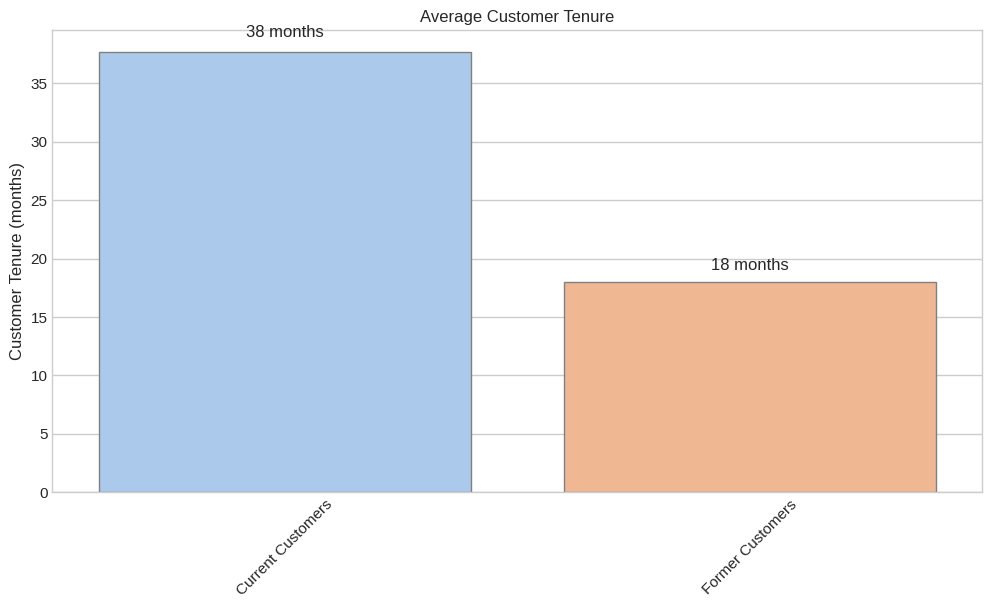

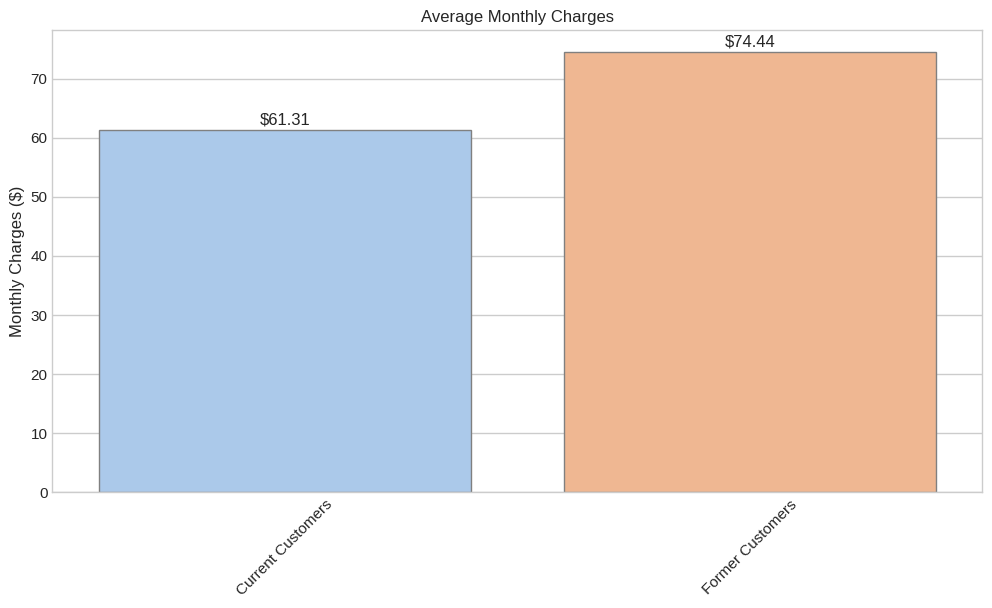

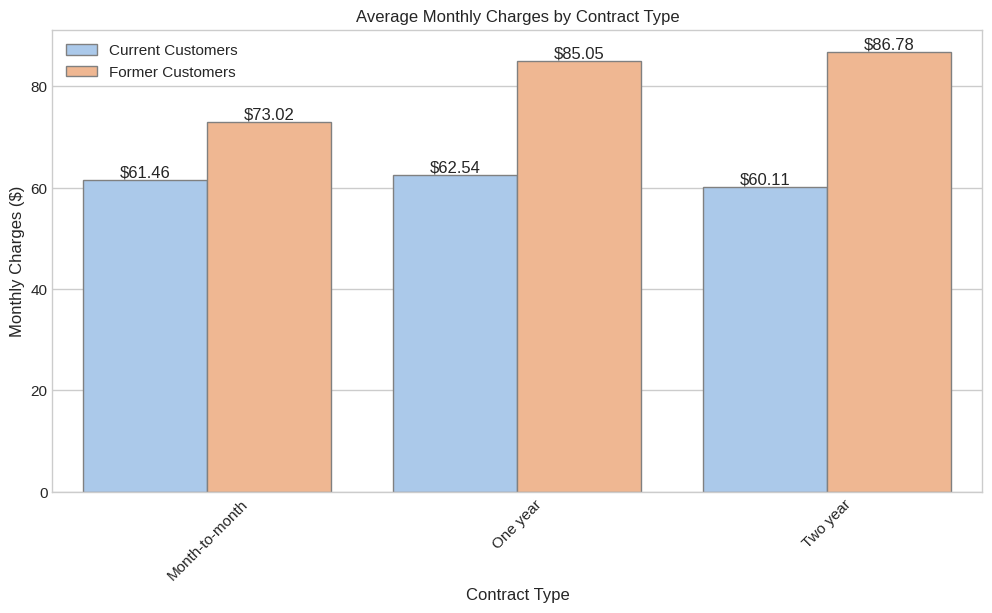

In [78]:
# Bar plot showing the average customer tenure for each Churn category
plt.figure(figsize=(12, 6))
sns.barplot(x='Churn2', y='tenure', data=telco, ci=None, palette='pastel', edgecolor='grey')
plt.title('Average Customer Tenure')
plt.ylabel('Customer Tenure (months)')
plt.xlabel('')
plt.xticks(rotation=45)
# Adding text annotations for average customer tenure
for index, value in enumerate(telco.groupby('Churn2')['tenure'].mean().round(0).astype(int)):
    plt.text(index, value + 1, f'{value} months', ha='center')

# Bar plot showing the average monthly charges for each Churn category
plt.figure(figsize=(12, 6))
sns.barplot(x='Churn2', y='MonthlyCharges', data=telco, ci=None, palette='pastel', edgecolor='grey')
plt.title('Average Monthly Charges')
plt.ylabel('Monthly Charges ($)')
plt.xlabel('')
plt.xticks(rotation=45)
# Adding text annotations for average monthly charges
for index, value in enumerate(telco.groupby('Churn2')['MonthlyCharges'].mean().round(2)):
    plt.text(index, value + 1, f'${value}', ha='center')

# Bar plot showing the average monthly charges by Contract type and Churn category
plt.figure(figsize=(12, 6))
sns.barplot(x='Contract', y='MonthlyCharges', hue='Churn2', data=telco, ci=None, palette='pastel', edgecolor='grey')
plt.title('Average Monthly Charges by Contract Type')
plt.ylabel('Monthly Charges ($)')
plt.xlabel('Contract Type')
plt.xticks(rotation=45)
plt.legend(title='')
# Adding text annotations for average monthly charges
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2., p.get_height(), f'${p.get_height():.2f}', ha='center', va='bottom')

plt.show()


The above visualizations depict the average tenure and monthly charges for both current and former customers of Telco. Current customers have, on average, maintained their services for a period slightly exceeding 3 years, whereas those who left had a tenure of approximately 18 months. Furthermore, former customers exhibited higher average monthly charges, amounting to an approximately $12 difference. This pattern remains consistent across all contract types.




## Types of Account Services Among Customers

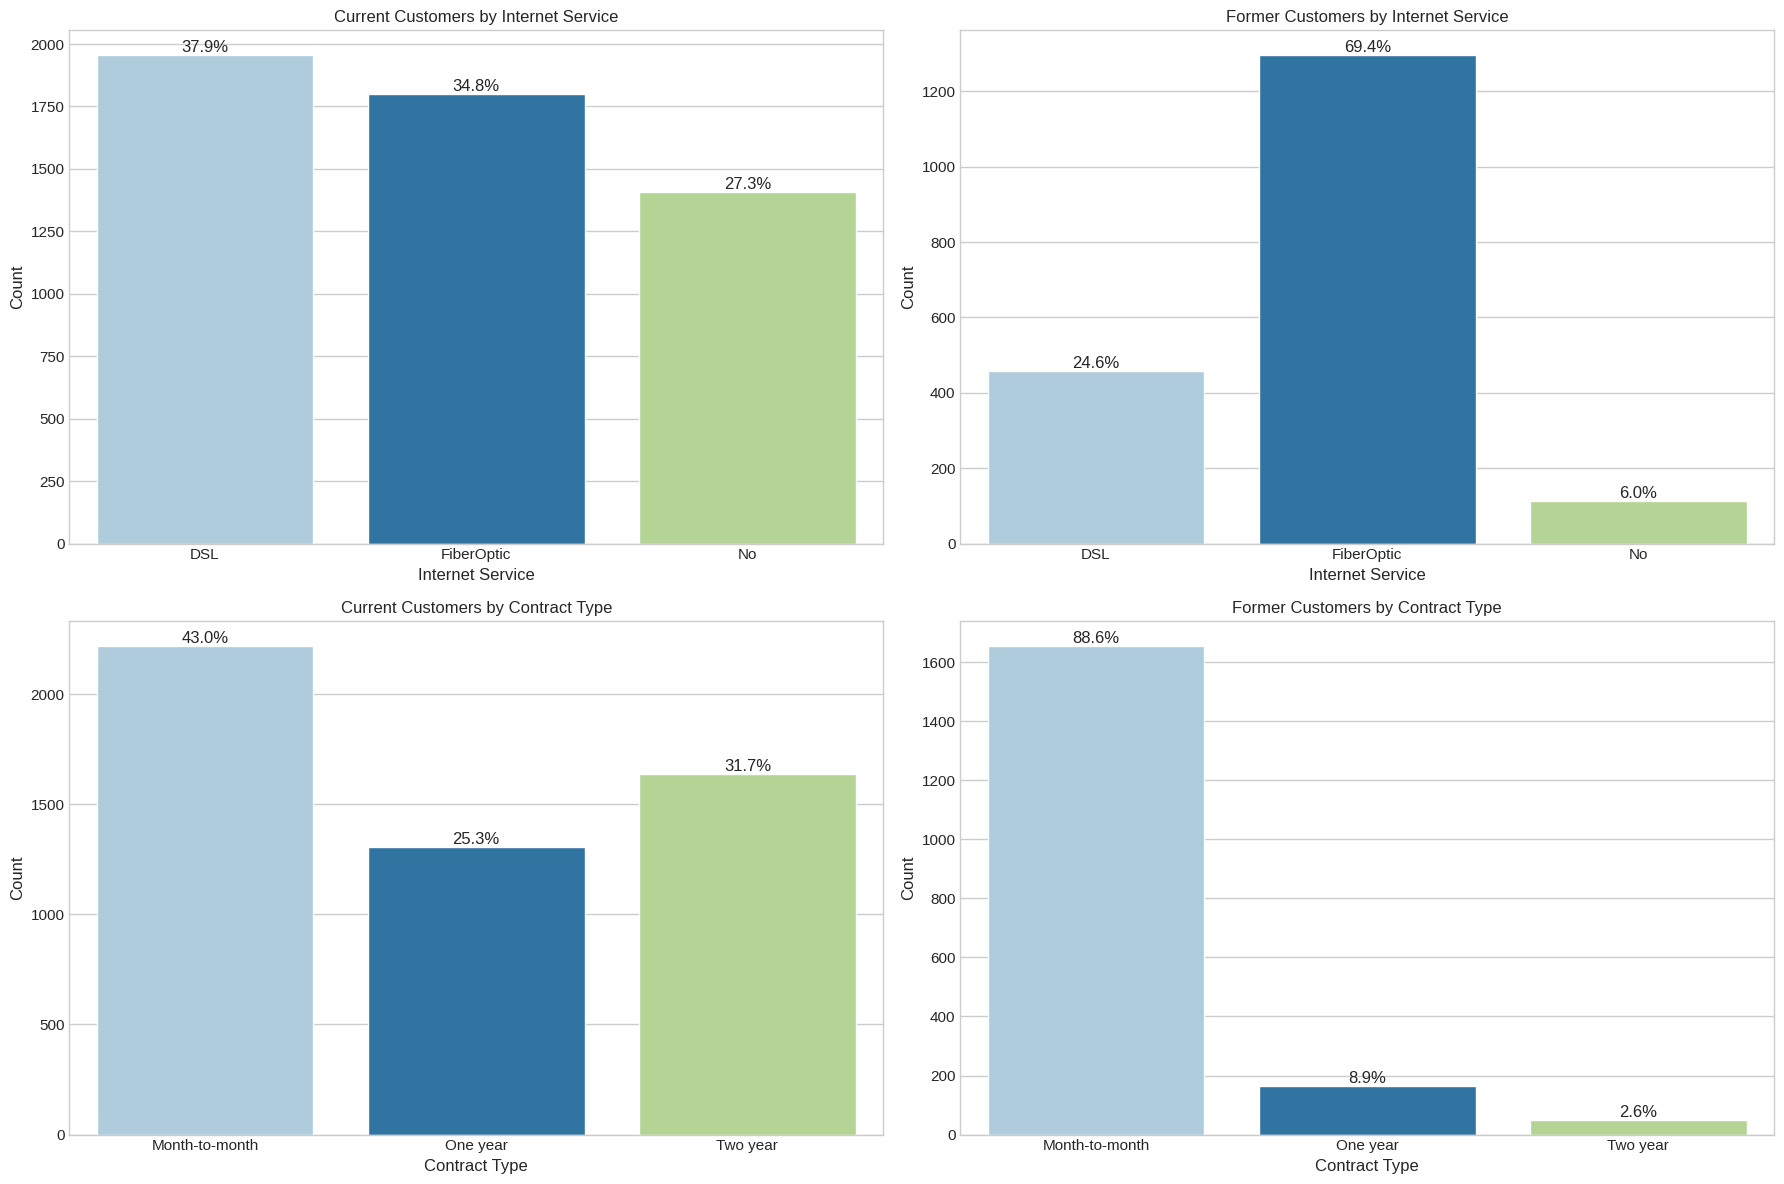

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for 'Current Customers' and 'Former Customers'
current_customers_data = telco[telco['Churn2'] == 'Current Customers']
former_customers_data = telco[telco['Churn2'] == 'Former Customers']

# Set up a 2x2 grid for the subplots
plt.figure(figsize=(18, 12))

# Plot 1: Current Customers by Internet Service
plt.subplot(2, 2, 1)
ax1 = sns.countplot(x='InternetService', data=current_customers_data, palette='Paired')
plt.title('Current Customers by Internet Service')
plt.xlabel('Internet Service')
plt.ylabel('Count')

# Yüzde değerlerini hesapla ve grafik üzerine ekle
total_current_internet = len(current_customers_data)
for p in ax1.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    percentage = f'{y/total_current_internet*100:.1f}%'
    ax1.annotate(percentage, (x, y), ha='center', va='bottom')



# Plot 3: Former Customers by Internet Service
plt.subplot(2, 2, 2)
ax2 = sns.countplot(x='InternetService', data=former_customers_data, palette='Paired')
plt.title('Former Customers by Internet Service')
plt.xlabel('Internet Service')
plt.ylabel('Count')

# Yüzde değerlerini hesapla ve grafik üzerine ekle
total_former_internet = len(former_customers_data)
for p in ax2.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    percentage = f'{y/total_former_internet*100:.1f}%'
    ax2.annotate(percentage, (x, y), ha='center', va='bottom')

# Plot 2: Current Customers by Contract Type
plt.subplot(2, 2, 3)
ax3 = sns.countplot(x='Contract', data=current_customers_data, palette='Paired')
plt.title('Current Customers by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')

# Yüzde değerlerini hesapla ve grafik üzerine ekle
total_current_contract = len(current_customers_data)
for p in ax3.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    percentage = f'{y/total_current_contract*100:.1f}%'
    ax3.annotate(percentage, (x, y), ha='center', va='bottom')



# Plot 4: Former Customers by Contract Type
plt.subplot(2, 2, 4)
ax4 = sns.countplot(x='Contract', data=former_customers_data, palette='Paired')
plt.title('Former Customers by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')

# Yüzde değerlerini hesapla ve grafik üzerine ekle
total_former_contract = len(former_customers_data)
for p in ax4.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    percentage = f'{y/total_former_contract*100:.1f}%'
    ax4.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()  # To prevent overlapping of subplots
plt.show()


Approximately 89% of the customers who churned were subscribed to month-to-month contracts, with a significantly smaller percentage opting for one or two-year contracts. Additionally, among the customers who left, slightly over 69% were using Fiber Optic internet. This observation might suggest a potential dissatisfaction with the service, prompting the company to conduct a more in-depth review. It is noteworthy, as currently, over a third of their existing customers are utilizing this type of internet connection.



## Demographics of Customer Attrition

In [87]:
df = telco

Check if there is any gender information for Current Customers
if 'Male' not in current_gender_counts:
    current_gender_counts['Male'] = 0
if 'Female' not in current_gender_counts:
    current_gender_counts['Female'] = 0
    


Check if there is any gender information for Former Customers
if 'Male' not in former_gender_counts:
    former_gender_counts['Male'] = 0
if 'Female' not in former_gender_counts:
    former_gender_counts['Female'] = 0
    

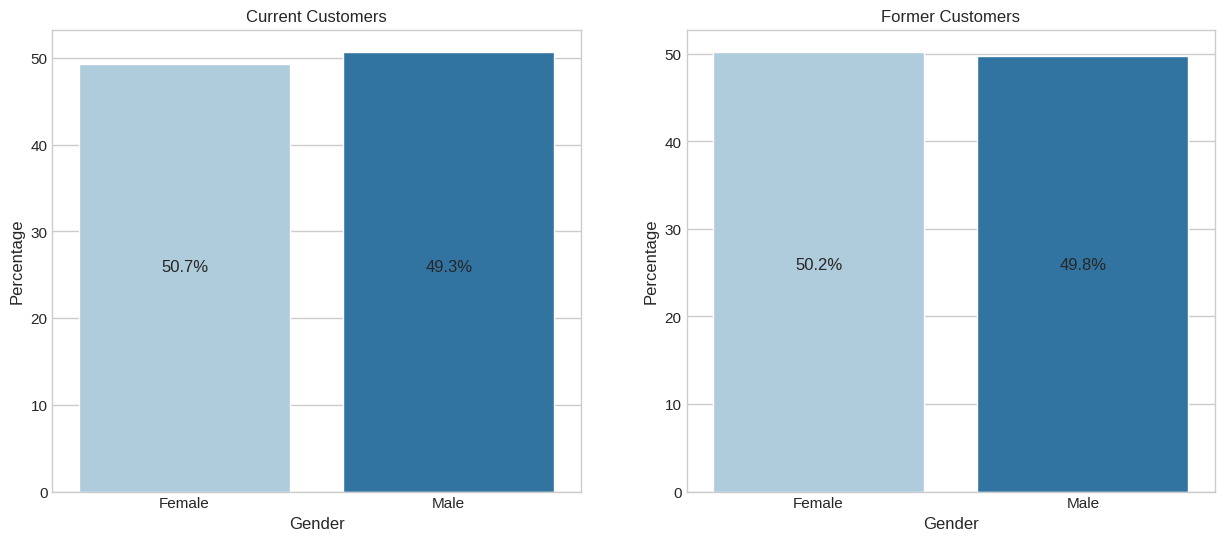

In [88]:

t1 = df.copy()

# Calculate percentages for Current Customers
current_customers = t1[t1['Churn2'] == 'Current Customers']
current_gender_counts = current_customers['gender'].value_counts()



# Calculate percentages
current_gender_percentages = (current_gender_counts / current_gender_counts.sum()) * 100

# Calculate percentages for Former Customers
former_customers = t1[t1['Churn2'] == 'Former Customers']
former_gender_counts = former_customers['gender'].value_counts()



# Calculate percentages
former_gender_percentages = (former_gender_counts / former_gender_counts.sum()) * 100

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Current Customers
sns.barplot(x=current_gender_percentages.index, y=current_gender_percentages.values, palette='Paired', ax=axes[0])
axes[0].set_title('Current Customers')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Percentage')

# Annotate percentages on the bars
for index, value in enumerate(current_gender_percentages.values):
    axes[0].text(index, 25, f'{value:.1f}%', ha='center', va='bottom')

# Plot for Former Customers
sns.barplot(x=former_gender_percentages.index, y=former_gender_percentages.values, palette='Paired', ax=axes[1])
axes[1].set_title('Former Customers')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Percentage')

# Annotate percentages on the bars
for index, value in enumerate(former_gender_percentages.values):
    axes[1].text(index, 25 , f'{value:.1f}%', ha='center', va='bottom')

plt.show()


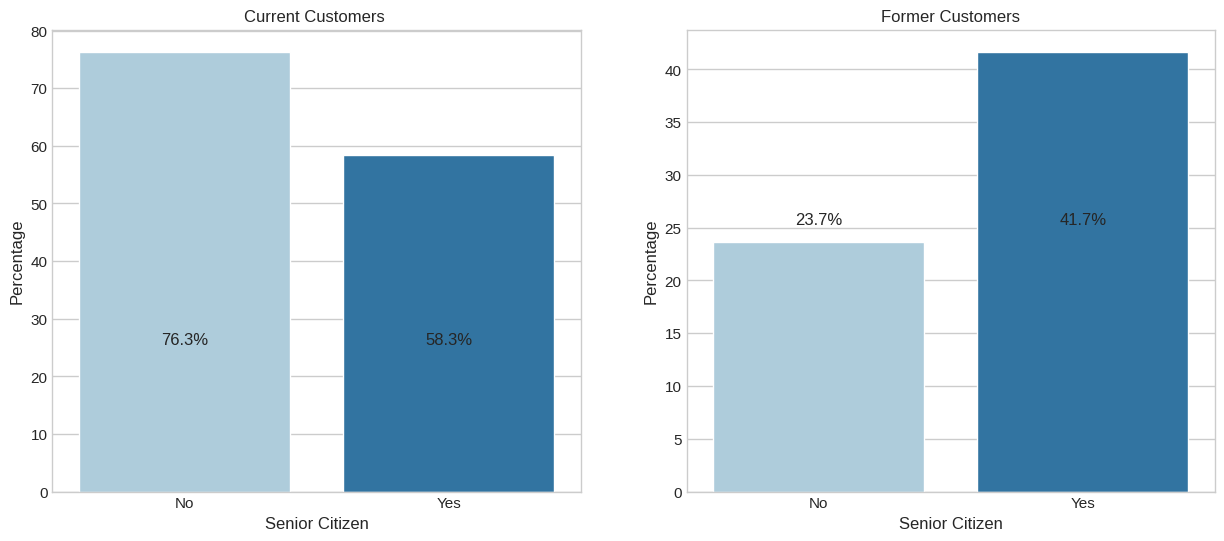

In [89]:

t2 = df.copy()

# Convert SeniorCitizen to categorical variable
t2['SeniorCitizen'] = t2['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

# Calculate percentages
total_counts = t2.groupby(['SeniorCitizen', 'Churn2']).size().reset_index(name='total_counts')
total_senior = total_counts[total_counts['SeniorCitizen'] == 'Yes']['total_counts'].sum()

total_counts['percentage'] = (total_counts['total_counts'] / total_counts.groupby('SeniorCitizen')['total_counts'].transform('sum')) * 100

# Separate into Current and Former Customers
current_customers = total_counts[total_counts['Churn2'] == 'Current Customers']
former_customers = total_counts[total_counts['Churn2'] == 'Former Customers']

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Current Customers
sns.barplot(x='SeniorCitizen', y='percentage', data=current_customers, palette='Paired', ax=axes[0])
axes[0].set_title('Current Customers ')
axes[0].set_xlabel('Senior Citizen')
axes[0].set_ylabel('Percentage')

# Annotate percentages on the bars
for index, value in enumerate(current_customers['percentage']):
    axes[0].text(index, 25, f'{value:.1f}%', ha='center', va='bottom')

# Plot for Former Customers
sns.barplot(x='SeniorCitizen', y='percentage', data=former_customers, palette='Paired', ax=axes[1])
axes[1].set_title('Former Customers')
axes[1].set_xlabel('Senior Citizen')
axes[1].set_ylabel('Percentage')

# Annotate percentages on the bars
for index, value in enumerate(former_customers['percentage']):
    axes[1].text(index, 25, f'{value:.1f}%', ha='center', va='bottom')

plt.show()


In [90]:
df.SeniorCitizen.value_counts(normalize=True)

0    0.8376
1    0.1624
Name: SeniorCitizen, dtype: float64

Considering the demographic characteristics of Telco's customer base, around 24% of those who discontinued their services were senior citizens, while just under 16% of the existing customer base is aged 65 or older. The gender distribution remains proportionate in both current and former customers, with a nearly equal number of men and women opting to discontinue services.



## Distributions and Correlations


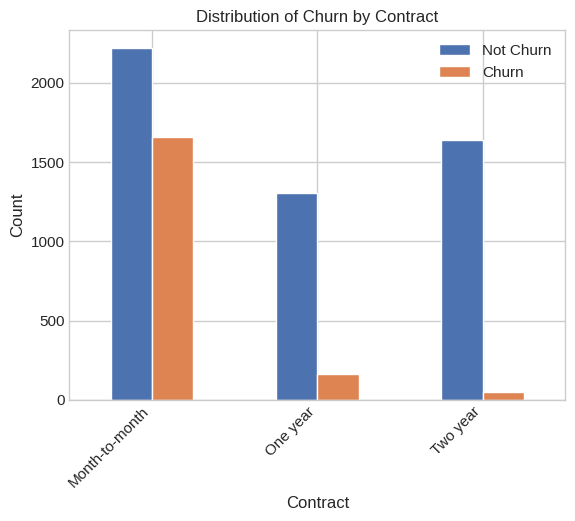

In [91]:
#Lets see salary vs churn status
grouped_data = df.groupby(['Contract', 'Churn']).size().unstack()
ax= grouped_data.plot(kind='bar', stacked=False)
plt.xlabel('Contract')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Distribution of Churn by Contract')
plt.legend( labels=['Not Churn', 'Churn'])
plt.show()

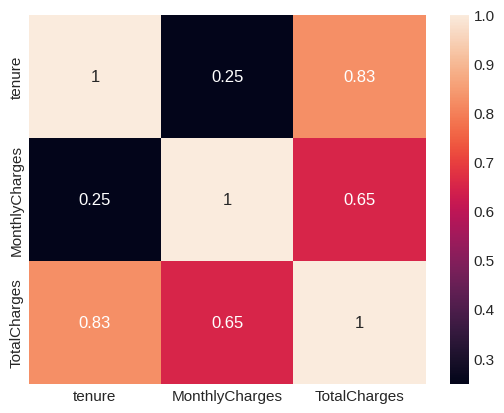

In [92]:
sns.heatmap(df.corr(), annot=True);

There is a corr between tenure and totalcharges.

In [93]:

new_df = df.copy()
new_df['Churn'] = new_df['Churn'].map({'Yes': 1, 'No': 0}).astype(int)


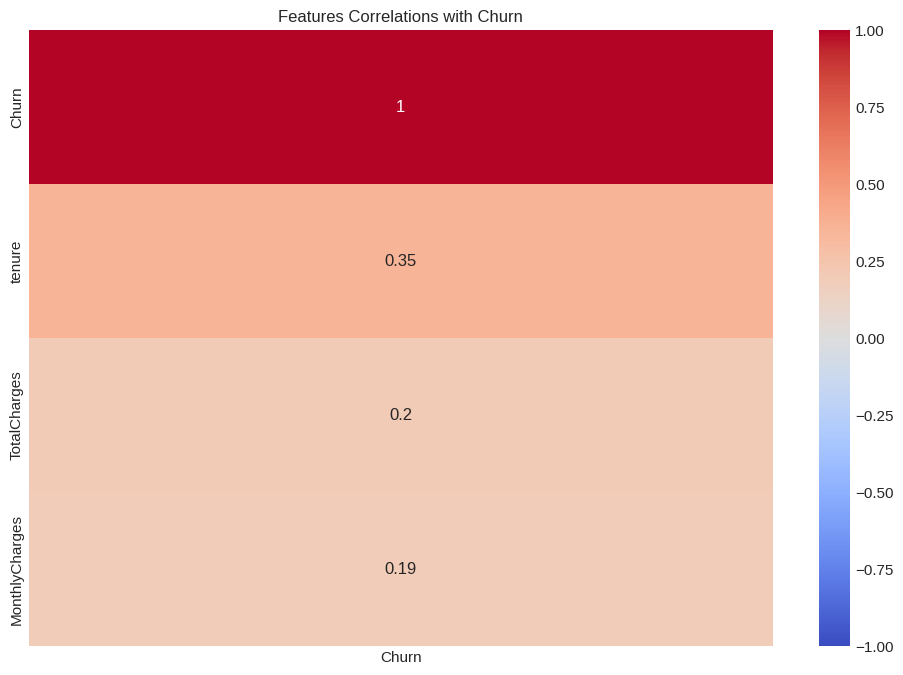

In [94]:
# How is correlation with Churn
target_column = 'Churn'
corr_matrix = new_df.corr()
corr_with_target = corr_matrix[target_column].apply(np.abs).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title(f'Features Correlations with {target_column}')
plt.show()

There is no singificant correlation with churn. We look into that later

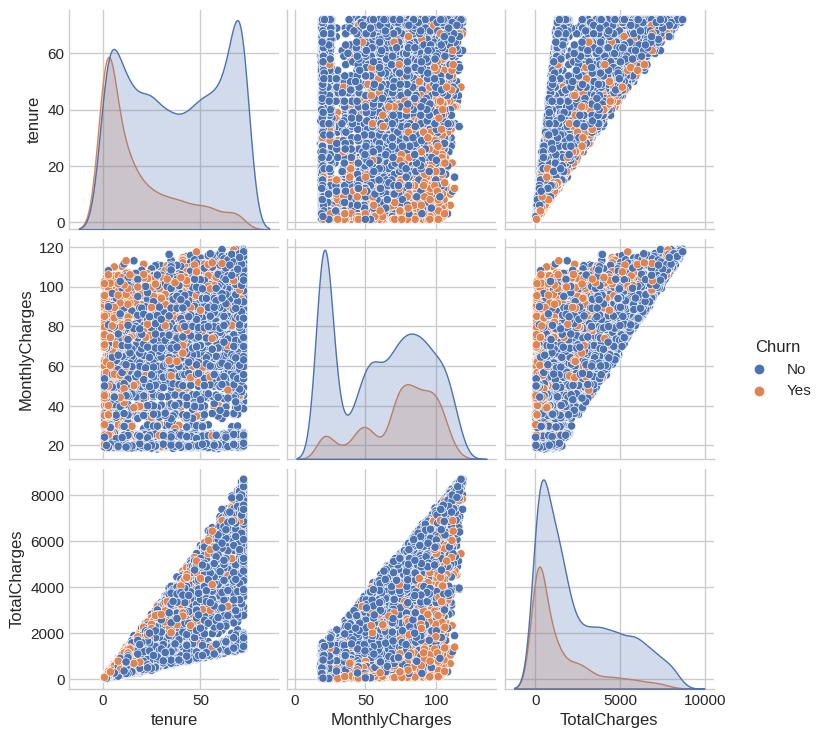

In [95]:
sns.pairplot(df,hue='Churn');

In [96]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   SeniorCitizen     7032 non-null   category
 2   Partner           7032 non-null   category
 3   Dependents        7032 non-null   category
 4   tenure            7032 non-null   int64   
 5   PhoneService      7032 non-null   category
 6   MultipleLines     7032 non-null   category
 7   InternetService   7032 non-null   category
 8   OnlineSecurity    7032 non-null   category
 9   OnlineBackup      7032 non-null   category
 10  DeviceProtection  7032 non-null   category
 11  TechSupport       7032 non-null   category
 12  StreamingTV       7032 non-null   category
 13  StreamingMovies   7032 non-null   category
 14  Contract          7032 non-null   category
 15  PaperlessBilling  7032 non-null   category
 16  PaymentMethod     7032 n

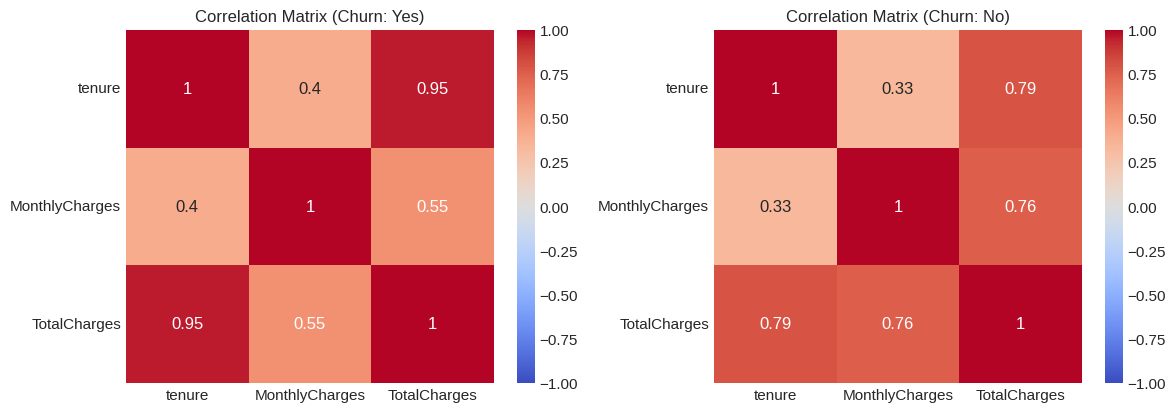

In [97]:
# We explore the correlation based on Churn

# Filtering for 'Churn: Yes'
churn_yes_df = new_df[new_df['Churn'] == 1]

# Filtering for 'Churn: No'
churn_no_df = new_df[new_df['Churn'] == 0]

# Calculating correlations
correlation_yes = churn_yes_df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()
correlation_no = churn_no_df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()

# Visualizing correlation matrices
plt.figure(figsize=(12, 8))

# Subplot for 'Churn: Yes'
plt.subplot(2, 2, 1)
sns.heatmap(correlation_yes, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix (Churn: Yes)')

# Subplot for 'Churn: No'
plt.subplot(2, 2, 2)
sns.heatmap(correlation_no, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix (Churn: No)')

plt.tight_layout()
plt.show()


The things changed here! The correlations among numeric variables reveal a strong association between TotalCharges and customer tenure, particularly noticeable among customers who left (Churn = Yes), boasting a correlation exceeding 0.95. Additionally, there exists a slightly positive relationship of 0.40 between MonthlyCharges and tenure. Examining the histograms, MonthlyCharges exhibits a distinctive multimodal shape. Meanwhile, the distribution of customer tenure appears relatively uniform among current customers but is skewed to the right for those who have left.







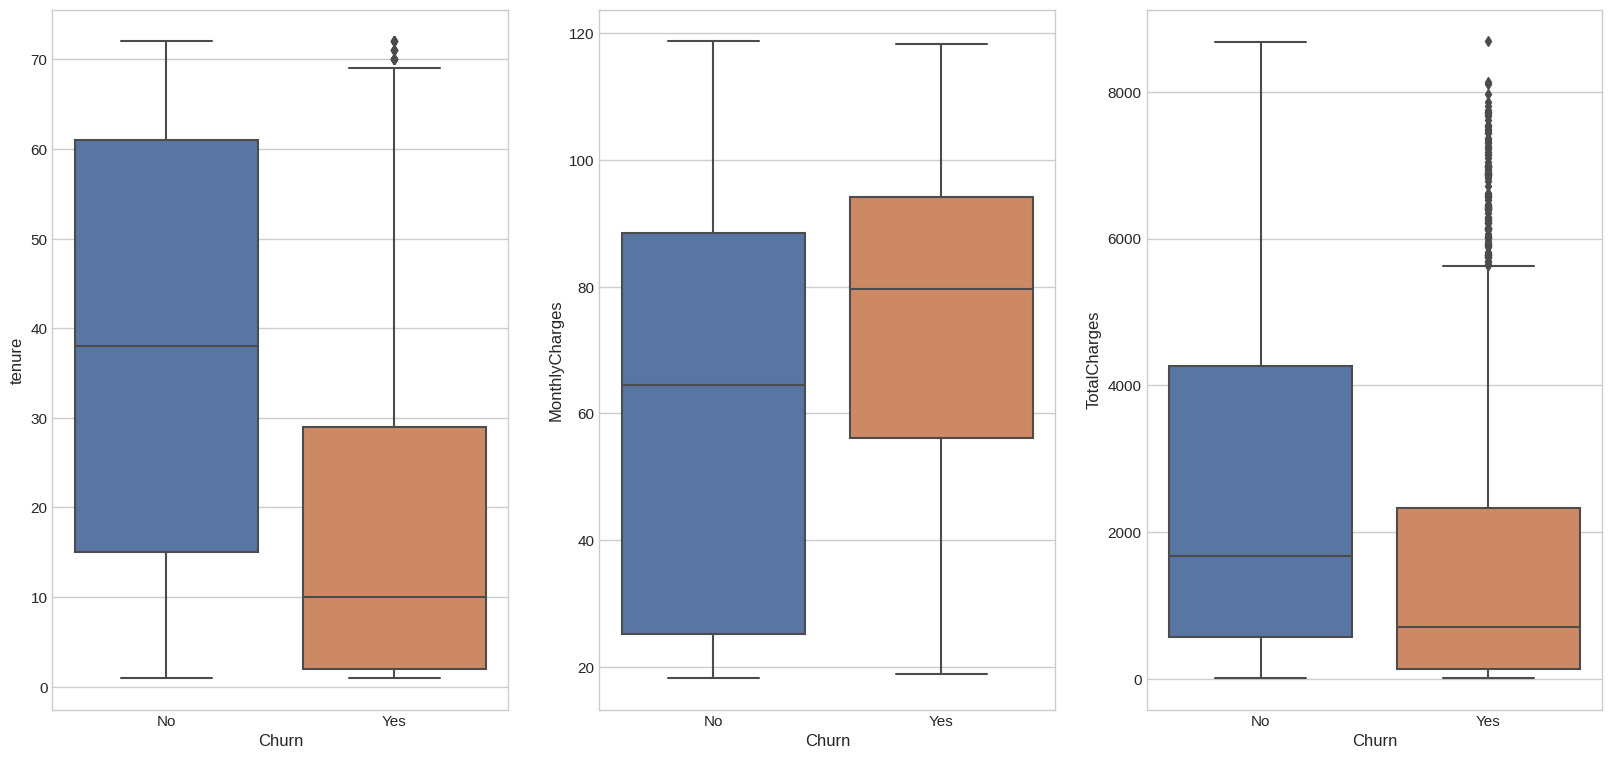

In [98]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

index = 0
plt.figure(figsize=(20, 20))
for feature in numerical_columns:
    if feature != "Churn":
        index += 1
        plt.subplot(2, 3, index)
        sns.boxplot(x='Churn', y=feature, data=df)
plt.show()


Customers with expensive contracts have experienced Churn, as depicted by the box plot  and the accompanying bar plot illustrating average monthly charges by contract type. These visualizations highlight both the median values and the higher prices associated with Churn.

## Data Preprocessing

The target variable, Churn, exhibits significant imbalance, with slightly over 26% (1,869 customers) having left the company in the past month. Recognizing that class imbalance can adversely impact the precision and recall accuracy of statistical models, I will employ the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE artificially generates new instances of the minority class by leveraging the nearest neighbors of these cases and simultaneously under-samples the majority class, resulting in a more balanced dataset. Following the application of SMOTE, our training set now comprises an equal proportion of current and former customers.

In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE



# Remove Churn and Churn2 columns
X = df.drop(['Churn', 'Churn2'], axis=1)
y = df['Churn']

# change categorical data to numerical
X = pd.get_dummies(X, drop_first=True)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)




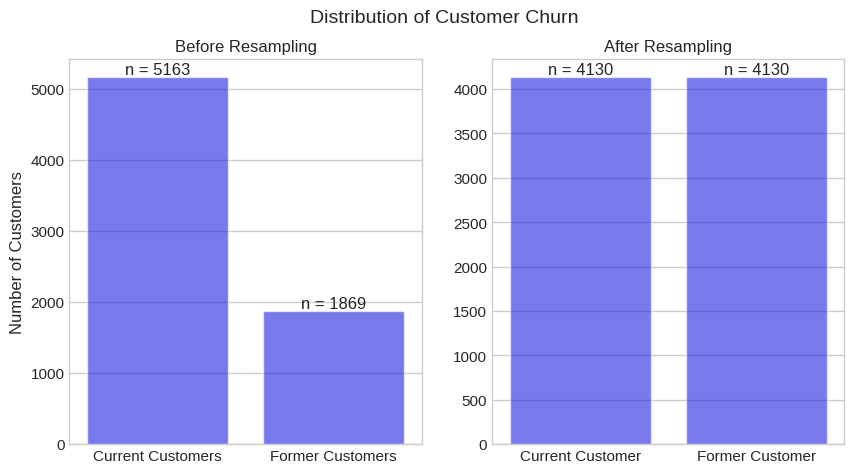

In [100]:


# Churn distribution
plt.figure(figsize=(10, 5))

# Before Resampling
plt.subplot(1, 2, 1)
sns.countplot(x='Churn2', data=df.replace({'Churn': {1: 'Former Customer', 0: 'Current Customer'}}),
              alpha=0.6, color='blue', label='Churn')
plt.text(0, df['Churn2'].value_counts()[0], f'n = {df["Churn2"].value_counts()[0]}', ha='center', va='bottom')
plt.text(1, df['Churn2'].value_counts()[1], f'n = {df["Churn2"].value_counts()[1]}', ha='center', va='bottom')
plt.title('Before Resampling')
plt.xlabel('')
plt.ylabel('Number of Customers')


# After Resampling
plt.subplot(1, 2, 2)
sns.countplot(x='Churn2', data=pd.DataFrame({'Churn2': y_train_resampled}).replace({'Churn2': {'Yes': 'Former Customer', 'No': 'Current Customer'}}),
              alpha=0.6, color='blue')
plt.text(0, pd.Series(y_train_resampled).value_counts()[0], f'n = {pd.Series(y_train_resampled).value_counts()[0]}', ha='center', va='bottom')
plt.text(1, pd.Series(y_train_resampled).value_counts()[1], f'n = {pd.Series(y_train_resampled).value_counts()[1]}', ha='center', va='bottom')
plt.title('After Resampling')
plt.xlabel('')
plt.ylabel('')
plt.legend()

plt.suptitle('Distribution of Customer Churn', fontsize=14)
plt.show()



----Feature Selection----

To determine the features to be incorporated into the models, I will assess the chi-squared tests of independence between the categorical features, retaining only variables that exhibit a statistically significant association with our response variable, "Churn".

 Chi-Squared Test



In [101]:
import pandas as pd
from scipy.stats import chi2_contingency

# select categorical cat_var
cat_feat = telco.select_dtypes(include='category')

# chi-square  for each categorical variable
chi_results = []


for column in cat_feat.columns:
    contingency_table = pd.crosstab(cat_feat[column], telco['Churn'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    chi_results.append({'Variable': column, 'Chi-Square': chi2, 'P-Value': p_value})


chi_results_df = pd.DataFrame(chi_results)

# P value
chi_results_df = chi_results_df.sort_values(by='P-Value')


chi_results_df = chi_results_df.round({'Chi-Square': 3, 'P-Value': 3})

print(chi_results_df)


            Variable  Chi-Square  P-Value
17            Churn2    7026.876    0.000
16             Churn    7026.876    0.000
13          Contract    1179.546    0.000
6    InternetService     728.696    0.000
15     PaymentMethod     645.430    0.000
14  PaperlessBilling     256.875    0.000
7     OnlineSecurity     205.416    0.000
10       TechSupport     189.967    0.000
3         Dependents     186.322    0.000
1      SeniorCitizen     158.441    0.000
2            Partner     157.503    0.000
8       OnlineBackup      47.247    0.000
9   DeviceProtection      30.496    0.000
11       StreamingTV      27.842    0.000
12   StreamingMovies      25.764    0.000
5      MultipleLines      11.087    0.001
4       PhoneService       0.874    0.350
0             gender       0.475    0.490


The Chi-Squared Test of Independence assesses the correlation between two categorical variables. The null hypothesis posits that there is no connection between our response variable and the categorical feature, while the alternative hypothesis suggests the presence of a relationship. Analyzing the test results, Gender and PhoneService exhibit minimal chi-squared statistics with p-values exceeding the significance threshold,
α, of 0.05, indicating their independence from our target variable. Conversely, the remaining categorical features demonstrate a statistically significant association with customer churn.

## Variable Importance

The Random Forest algorithm employs two metrics to assess variable importance: mean decrease in Gini and mean decrease in accuracy. The mean decrease in Gini represents the average reduction in node impurities across all trees within the model, which results from splitting on a particular variable, as measured by the Gini index.

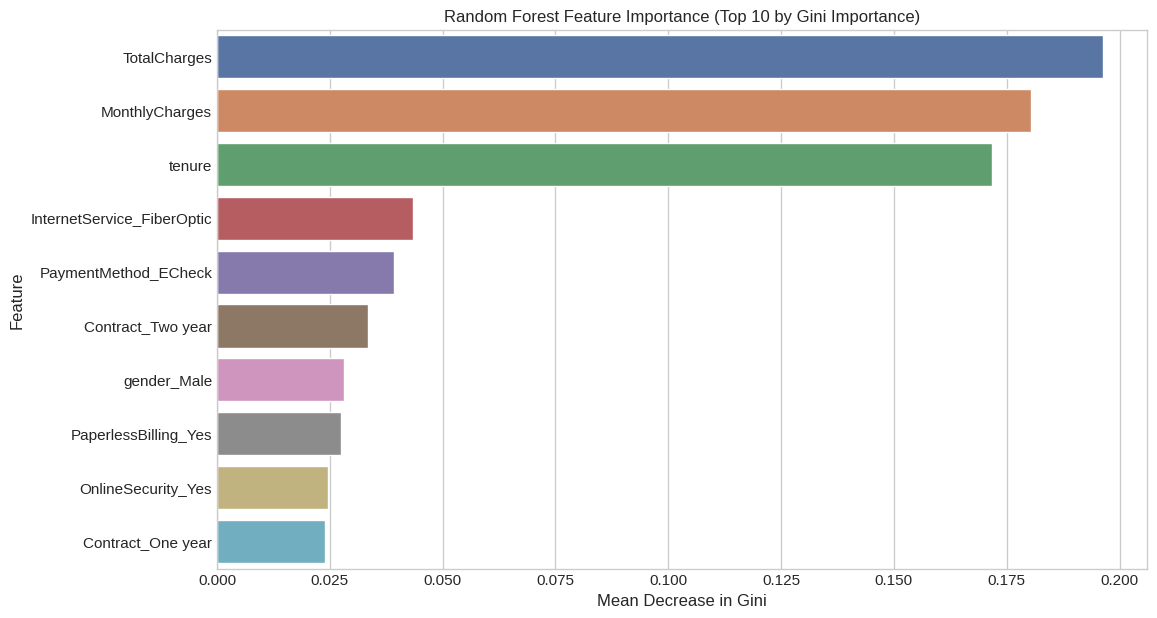

In [102]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the Random Forest classifier model
rf = RandomForestClassifier(n_estimators=100, random_state=1, oob_score=True)
rf.fit(X_scaled, y)

# Calculate feature importances and select the top 10 most important features
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
top_features_gini = feature_importances.head(10)

# Plot the sorted features by Gini importance
plt.figure(figsize=(12, 7))
sns.barplot(x=top_features_gini['importance'], y=top_features_gini.index)
plt.title('Random Forest Feature Importance (Top 10 by Gini Importance)')
plt.xlabel('Mean Decrease in Gini')
plt.ylabel('Feature')
plt.show()

# Plot the sorted features by Accuracy importance
# Note: scikit-learn does not provide a direct MeanDecreaseAccuracy feature, hence we only use Gini importance


In [ ]:
# Mean Decrease in Accuracy
# Computationally expensive

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate permutation importance to measure the impact on model accuracy
perm_importance = permutation_importance(rf, X_scaled, y, n_repeats=1, random_state=1)

# Select the top 10 most important features based on permutation importance
sorted_idx = perm_importance.importances_mean.argsort()[-10:]
top_features_perm = pd.DataFrame(perm_importance.importances[sorted_idx].T, columns=X.columns[sorted_idx])

# Plot the sorted features by permutation importance
plt.figure(figsize=(12, 7))
sns.barplot(data=top_features_perm, orient='h')
plt.title('Random Forest Feature Importance (Top 10 by Permutation Importance)')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Feature')
plt.show()


The visualization of key variables indicates that  Tenure, TotalCharges, MonthlyCharges, InternetService, PaymentMethod, Contract, OnlineSecurity, TechSupport, and PaperlessBilling are significant according to the mean decrease in Gini metric.

## Predicting Customer Churn


-- Methodology--

To discern which customers are at a higher risk of churning, various classification models will be assessed, including logistic regression, support vector machines, and random forests. Given that the numerical predictors, MonthlyCharges and Tenure, exhibit skewed distributions and are on different scales, a preprocessing step will be implemented to normalize the features, ensuring they have a mean of zero and a standard deviation of one.

For model fitting, 5-fold cross-validation will be employed, and the models' performance will be evaluated on an out-of-sample dataset. This dataset has been excluded from the resampling process and better reflects the actual distribution of classes.



--Random Forest--

In [177]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression

# Identify categorical and numerical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create a transformer to convert categorical data to numerical format
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  # No need to scale numerical features for Random Forest
        ('cat', OneHotEncoder(), categorical_features)])  # Apply OneHotEncoder to categorical features

# Convert the target variable to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create and train the Random Forest model on the training set
rf_model = RandomForestClassifier(random_state=42)
pipeline_rf_feat = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', rf_model)])
pipeline_rf_feat.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = pipeline_rf_feat.predict(X_test)

# Calculate and print the confusion matrix and classification report
cm_rf = confusion_matrix(y_test, y_pred_rf)
cr_rf = classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_)

# Calculate and print the ROC AUC score
roc_auc_rf = roc_auc_score(y_test, pipeline_rf_feat.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred_rf)

# Print the results
print(f"Confusion Matrix :\n{cm_rf}\n")
print(f"Classification Report :\n{cr_rf}\n")
print(f"Accuracy Score: {accuracy:.3f}")
print(f"ROC AUC Score:  {roc_auc_rf:.3f}")


Confusion Matrix :
[[908 125]
 [216 158]]

Classification Report :
              precision    recall  f1-score   support

          No       0.81      0.88      0.84      1033
         Yes       0.56      0.42      0.48       374

    accuracy                           0.76      1407
   macro avg       0.68      0.65      0.66      1407
weighted avg       0.74      0.76      0.75      1407


Accuracy Score: 0.758
ROC AUC Score:  0.765


--Logistic Regression--

Logistic regression is a parametric classification method that calculates the likelihood of an event's occurrence, such as whether a customer will churn. An advantage of logistic regression is the interpretability of its model parameters. The model can quantify the relationship between the response and input features by examining the magnitude of the coefficients and the significance of the predictors.

In [105]:
# Remove Churn and Churn2 columns
#X = df.drop(['Churn', 'Churn2'], axis=1)
#y = df['Churn']


In [ ]:
#y_encoded = label_encoder.fit_transform(y)

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Define categorical and numerical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create a preprocessor to convert categorical data to numerical format and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('cat', OneHotEncoder(), categorical_features)])  # One-hot encode categorical features

# Convert the target variable to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Create a pipeline with preprocessing, SMOTE, and logistic regression model
pipeline_lr = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42))
])

# Train the model using the pipeline
pipeline_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline_lr.predict(X_test)

# Calculate performance metrics
cm_lr = confusion_matrix(y_test, y_pred)
cr_lr = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# To calculate the ROC AUC score, first apply transformations to the test set using the preprocessor
# Then call the predict_proba method on the trained logistic regression model
# Extract the logistic regression model from the pipeline
logistic_regression_model = pipeline_lr.named_steps['model']
# Extract the preprocessor from the pipeline
preprocessor = pipeline_lr.named_steps['preprocessor']
# Apply transformations to the test set
X_test_transformed = preprocessor.transform(X_test)
# Calculate ROC AUC score using the transformed test set and the logistic regression model
roc_auc = roc_auc_score(y_test, logistic_regression_model.predict_proba(X_test_transformed)[:, 1])

# Print the results
print(f"Confusion Matrix:\n{cm_lr}\n")
print(f"Classification Report:\n{cr_lr}\n")
print(f"Accuracy Score: {accuracy:.3f}")
print(f"ROC AUC Score: {roc_auc:.3f}")


Confusion Matrix:
[[927 106]
 [211 163]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1033
           1       0.61      0.44      0.51       374

    accuracy                           0.77      1407
   macro avg       0.71      0.67      0.68      1407
weighted avg       0.76      0.77      0.76      1407


Accuracy Score: 0.775
ROC AUC Score: 0.811


In [130]:
# Feature Engineering without SMOTE in Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression


# Identify categorical and numerical features
categorical_features = ['InternetService', 'PaymentMethod', 'Contract', 'OnlineSecurity', 'TechSupport', 'PaperlessBilling']
numerical_features = ['tenure', 'MonthlyCharges', "TotalCharges"]

# Create a transformer to convert categorical data to numerical format
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Apply StandardScaler to numerical features
        ('cat', OneHotEncoder(), categorical_features)])  # Apply OneHotEncoder to categorical features

# Convert the target variable to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create and train the model on the training set
model = LogisticRegression()
pipeline_lr_feat = Pipeline(steps=[('preprocessor', preprocessor),  # Include preprocessing in the pipeline
                           ('model', model)])  # Add the logistic regression model to the pipeline
pipeline_lr_feat.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline_lr_feat.predict(X_test)

# Calculate and print the confusion matrix and classification report
cm_lr_feat = confusion_matrix(y_test, y_pred)
cr_lr_feat = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Calculate and print the ROC AUC score
roc_auc = roc_auc_score(y_test, pipeline_lr_feat.predict_proba(X_test)[:, 1])

# Print the results
print(f"Confusion Matrix:\n{cm_lr_feat}\n")
print(f"Classification Report:\n{cr_lr_feat}\n")
print(f"ROC AUC Score: {roc_auc:.3f}")



Confusion Matrix:
[[916 117]
 [179 195]]

Classification Report:
              precision    recall  f1-score   support

          No       0.84      0.89      0.86      1033
         Yes       0.62      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


ROC AUC Score: 0.831


We select some features that are mean decrease in Gini except gender.

In [108]:
categorical_features1 = ['InternetService', 'PaymentMethod', 'Contract', 'OnlineSecurity', 'TechSupport', 'PaperlessBilling']
numerical_features1 = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [132]:
#Feature engineering with  SMOTE in Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb  # SMOTE ile uyumlu pipeline
from imblearn.over_sampling import SMOTE

# Split the dataset into features and target variable
X = df[numerical_features1 + categorical_features1]
y = df['Churn']

# Create a preprocessor to convert categorical data to numerical format
# Apply OneHotEncoder only to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features1),  # Standardize numerical features
        ('cat', OneHotEncoder(), categorical_features1)])  # One-hot encode categorical features

# Convert the target variable to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a logistic regression model using the resampled dataset with SMOTE
# Combine SMOTE and model training in a pipeline for streamlined processing
pipeline_lr_feat_sm = make_pipeline_imb(preprocessor, SMOTE(random_state=42), LogisticRegression(random_state=42))
pipeline_lr_feat_sm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline_lr_feat_sm.predict(X_test)

# Calculate performance metrics
cm_lr_feat_sm = confusion_matrix(y_test, y_pred)
cr_lr_feat_sm = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, pipeline_lr_feat_sm.predict_proba(X_test)[:, 1])

# Print the results
print(f"Confusion Matrix:\n{cm_lr_feat_sm}\n")
print(f"Classification Report:\n{cr_lr_feat_sm}\n")
print(f"Accuracy Score: {accuracy:.3f}")
print(f"ROC AUC Score: {roc_auc:.3f}")



Confusion Matrix:
[[723 310]
 [ 71 303]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.81      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.76      0.70      1407
weighted avg       0.80      0.73      0.74      1407


Accuracy Score: 0.729
ROC AUC Score: 0.832


The confusion matrix indicates that the model has a high number of true negatives (723) but also a significant number of false positives (303), suggesting that while it is fairly good at identifying the majority class (non-churn), it is prone to incorrectly predicting churn where it does not occur. The classification report shows a high recall (0.81) for the minority class (churn), meaning the model is quite effective at identifying customers who will churn, but the precision (0.49) is lower, indicating a higher rate of false positives within this group. Overall, the model achieves an accuracy score of 72.9% and a robust ROC AUC score of 0.832, which suggests that the model's ability to distinguish between the churn and non-churn classes is quite strong. However, the balance between precision and recall could be improved, particularly to reduce the number of false positives.

## Finding best parameters with GridSearchCV

In [172]:
from sklearn.model_selection import GridSearchCV

# Select features
selected_features = numerical_features + categorical_features
X_selected = X[selected_features]

# Split the dataset into training and testing sets
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    X_selected, y_encoded, test_size=0.2, random_state=42)

# Create a preprocessor for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('cat', OneHotEncoder(), categorical_features)])  # One-hot encode categorical features

# Create a pipeline with preprocessing and logistic regression model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LogisticRegression(random_state=42))])

# Define the hyperparameter grid
param_grid = {
    'model__C': [0.1, 1, 10, 100],  # Regularization strength
    'model__penalty': ['l1', 'l2'],  # Type of penalty
    'model__solver': ['liblinear']  # Optimization algorithm
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1)

# Run the grid search
grid_search.fit(X_train_selected, y_train)

# Print the best parameters and the best ROC AUC score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best ROC AUC: {grid_search.best_score_}")

# Make predictions on the test set
y_pred_gs = grid_search.predict(X_test_selected)

# Calculate performance metrics
cm_gs = confusion_matrix(y_test, y_pred_gs)
cr_gs = classification_report(y_test, y_pred_gs)
accuracy_gs = accuracy_score(y_test, y_pred_gs)
roc_auc_gs = roc_auc_score(y_test, grid_search.predict_proba(X_test_selected)[:, 1])

# Print the results
print(f"Confusion Matrix (Grid Search):\n{cm_gs}\n")
print(f"Classification Report (Grid Search):\n{cr_gs}\n")
print(f"Accuracy Score (Grid Search): {accuracy_gs:.3f}")
print(f"ROC AUC Score (Grid Search): {roc_auc_gs:.3f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best ROC AUC: 0.8112056329816095
Confusion Matrix (Grid Search):
[[937  96]
 [214 160]]

Classification Report (Grid Search):
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1033
           1       0.62      0.43      0.51       374

    accuracy                           0.78      1407
   macro avg       0.72      0.67      0.68      1407
weighted avg       0.76      0.78      0.76      1407


Accuracy Score (Grid Search): 0.780
ROC AUC Score (Grid Search): 0.800


## Support Vector Machine

In [146]:
#GridSearch with SMOTE in Support Vector Machine

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE

# Split the dataset into selected features and target variable
X = df[numerical_features + categorical_features]
y = df['Churn']

# Create a preprocessor to convert categorical data to numerical format
# Apply OneHotEncoder only to categorical features and StandardScaler to numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Convert the target variable to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train an SVM model using the resampled dataset with SMOTE
# Combine preprocessing, SMOTE, and SVM model training in a pipeline
pipeline_svm = make_pipeline_imb(preprocessor, SMOTE(random_state=42), SVC(probability=True, random_state=42))
pipeline_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline_svm.predict(X_test)

# Calculate performance metrics
cm_svm = confusion_matrix(y_test, y_pred)
cr_svm = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, pipeline_svm.predict_proba(X_test)[:, 1])

# Print the results
print(f"Confusion Matrix:\n{cm_svm}\n")
print(f"Classification Report:\n{cr_svm}\n")
print(f"Accuracy Score: {accuracy:.3f}")
print(f"ROC AUC Score: {roc_auc:.3f}")


Confusion Matrix:
[[712 321]
 [ 85 289]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.69      0.78      1033
           1       0.47      0.77      0.59       374

    accuracy                           0.71      1407
   macro avg       0.68      0.73      0.68      1407
weighted avg       0.78      0.71      0.73      1407


Accuracy Score: 0.711
ROC AUC Score: 0.787


## Model Performance on the Test Set

In [178]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

# Function to process the classification report string
def parse_classification_report(cr_string):
    # Split the string into lines
    lines = cr_string.strip().split('\n')
    # Find the 'accuracy' line
    accuracy_line = [line for line in lines if 'accuracy' in line][0]
    # Find the 'macro avg' line
    macro_avg_line = [line for line in lines if 'macro avg' in line][0]
    # Extract the metrics
    accuracy = float(accuracy_line.split()[1])
    macro_avg_metrics = macro_avg_line.split()
    precision = float(macro_avg_metrics[-4])
    recall = float(macro_avg_metrics[-3])
    f1_score = float(macro_avg_metrics[-2])
    # Create a DataFrame with the extracted metrics
    df = pd.DataFrame({
        'Accuracy': [accuracy],
        'Precision (Macro Avg)': [precision],
        'Recall (Macro Avg)': [recall],
        'F1 Score (Macro Avg)': [f1_score]
    })
    return df

# Create DataFrames for each model
cr_svm_df = parse_classification_report(cr_svm)
cr_gs_df = parse_classification_report(cr_gs)
cr_lr_feat_sm_df = parse_classification_report (cr_lr_feat_sm)
cr_lr_feat_df = parse_classification_report(cr_lr_feat)
cr_lr_df = parse_classification_report(cr_lr)
cr_rf_df = parse_classification_report(cr_rf)

all_cr_df = pd.concat([cr_svm_df, cr_gs_df, cr_lr_feat_sm_df, cr_lr_feat_df, cr_lr_df, cr_rf_df],
                      keys=['SVM', 'Grid Search LR', 'LR with Feature Selection and SMOTE',
                            'LR with Feature Selection', 'Logistic Regression', 'Random Forest'])



all_cr_df = all_cr_df.reset_index(level=0).rename(columns={'level_0': 'Model'})

# Reset the index of the DataFrame without adding a new index column

all_cr_df.reset_index(drop=True, inplace=True)

all_cr_df


,Model,Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 Score (Macro Avg)
0,SVM,0.71,0.68,0.73,0.68
1,Grid Search LR,0.78,0.72,0.67,0.68
2,LR with Feature Selection and SMOTE,0.73,0.70,0.76,0.70
3,LR with Feature Selection,0.79,0.73,0.70,0.71
4,Logistic Regression,0.77,0.71,0.67,0.68
5,Random Forest,0.76,0.68,0.65,0.66


The Logistic Regression model with SMOTE demonstrates improved performance in predicting churn, although it exhibits a lower precision. Despite this, it still manages to produce the highest recall metric for churn, indicating its effectiveness in identifying true positive cases.

Conclusion

Utilizing SMOTE and feature selection, logistic regression stands out as the most effective model for predicting customer churn, achieving the highest scores in Area Under the Curve and F1 metrics. Influential predictors such as Tenure, MonthlyCharges, InternetService, and Contract type are pivotal. The analysis indicates that targeting customers on month-to-month contracts, using fiber optic services, with higher monthly charges and less than 18 months of tenure could significantly aid Telco in lowering churn rates.